In [1]:
import keras
keras.__version__

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [2]:
import os 
import shutil
import nibabel as nib
import numpy as np
import pandas as pd 
from keras.models import load_model
from nilearn import image as nlimg

In [3]:
from keras import layers
from keras import models

model = models.Sequential()

#model.add(layers.AveragePooling3D(pool_size=(3, 3, 3), strides=None, padding='valid',input_shape=(192, 192, 160,1),data_format='channels_last'))
#model.add(layers.Conv3D(32, (3, 3, 3), activation='relu',padding='same'))

model.add(layers.AveragePooling3D(pool_size=(2, 2, 2), strides=None, padding='valid',
                         input_shape=(192, 192, 160,1),data_format='channels_last'))
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu',padding='same'))

model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(2, activation='sigmoid'))
model.add(layers.Dense(3, activation='softmax'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling3d_1 (Average (None, 96, 96, 80, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 96, 96, 80, 32)    896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 48, 48, 40, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 46, 46, 38, 64)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 23, 23, 19, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 21, 21, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 10, 8, 128)    0         
__________

In [5]:
from keras import optimizers

#model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1.0, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, 
              metrics=['accuracy'])

In [6]:
#model = load_model('CN_and_AD_3D_checkpoint.h5')
#model.load_weights('CN_and_AD_3D_checkpoint.h5')
model.load_weights('CN_AD_MCI_Conv3D_CV_GP2_checkpoint_0.h5')

In [7]:
import matplotlib.pyplot as plt

target_shape = [192,192,160]
target_affine = np.array([ [ 4.29048360e-08,  3.24291396e-04, -1.20006235e+00, 9.47253036e+01],
                            [-3.27969076e-04, -1.23945871e+00, -3.13983739e-04, 1.38530121e+02],
                            [-1.25348123e+00,  3.24300145e-04,  4.10763858e-08, 1.08530121e+02],
                            [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]
                    ])

NIfTI_img = nib.load('D:\\mri\\Test_MCI.nii')
img = nlimg.resample_img(NIfTI_img, target_affine=target_affine, target_shape=target_shape, interpolation='continuous', copy=True, order='F', clip=True)
img_data = img.get_data()
a_slice = img_data[:,32,:]
plt.imshow(a_slice,cmap='viridis')


C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


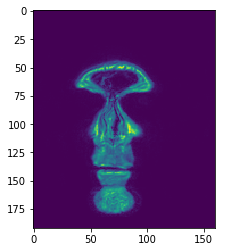

In [8]:
X = np.empty((1,192, 192, 160, 1))
#X[0,] = img_data
X[0,] = np.expand_dims(img_data, axis=4)
a_slice = X[0,:,32,:,0]
plt.imshow(a_slice,cmap='viridis')

In [9]:
print(X.shape)

(1, 192, 192, 160, 1)


In [10]:
layer_outputs = [layer.output for layer in model.layers[:9]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [11]:
activations = activation_model.predict(X)

In [12]:
first_layer_activation = activations[0]
#nib.save(first_layer_activation.shape, 'my_image.nii')
print(first_layer_activation.shape)

(1, 96, 96, 80, 1)


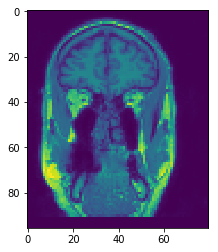

In [13]:
import matplotlib.pyplot as plt
a_slice = first_layer_activation[0,:,32,:,0]
plt.imshow(a_slice,cmap='viridis')
#plt.matshow(first_layer_activation[0, :, :,:, 1], cmap='viridis')

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


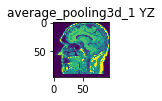

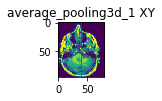

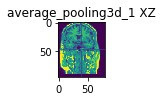

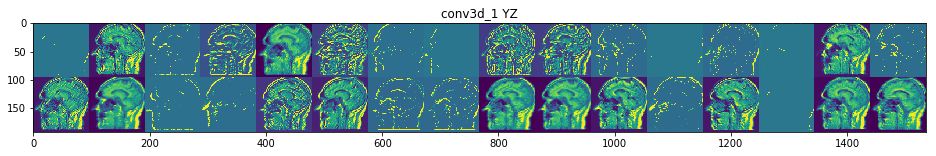

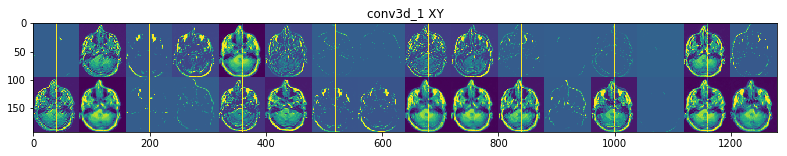

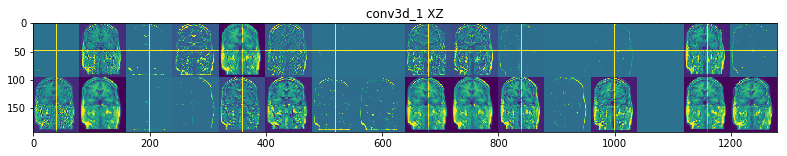

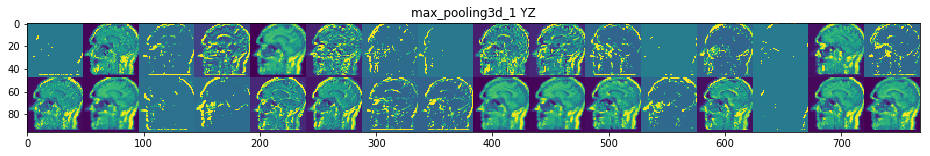

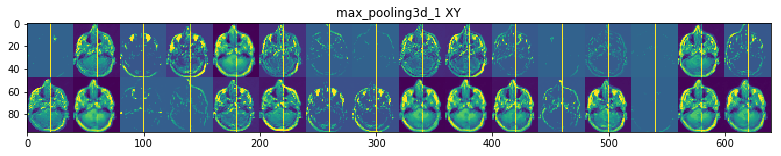

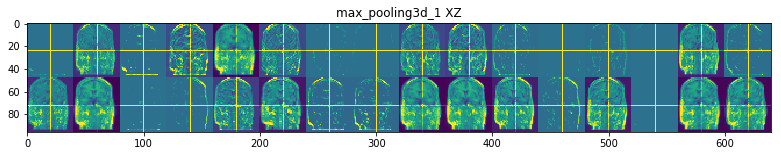

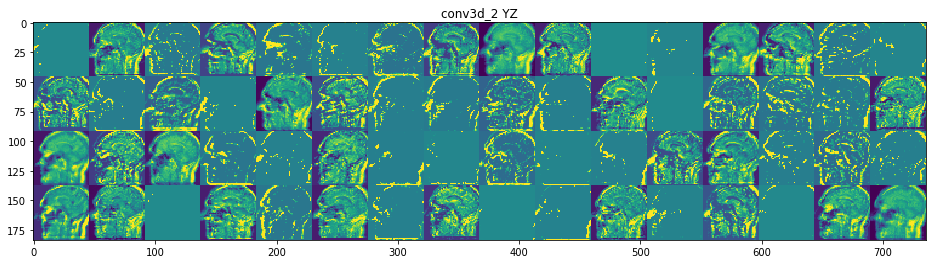

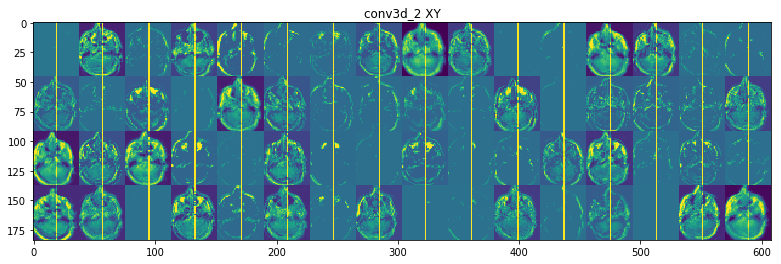

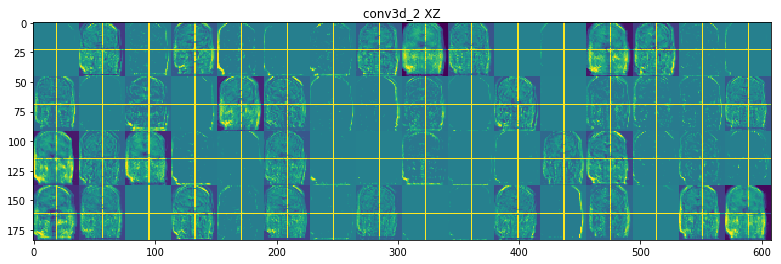

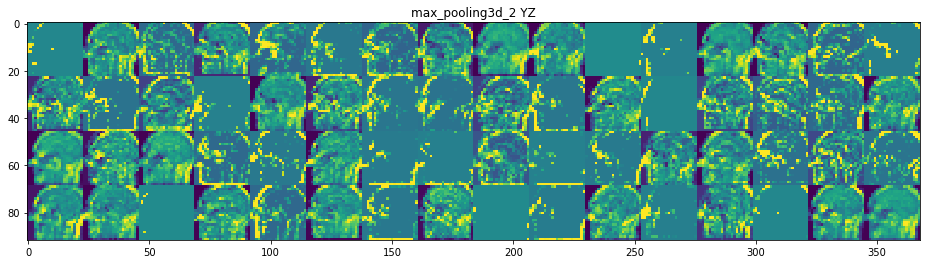

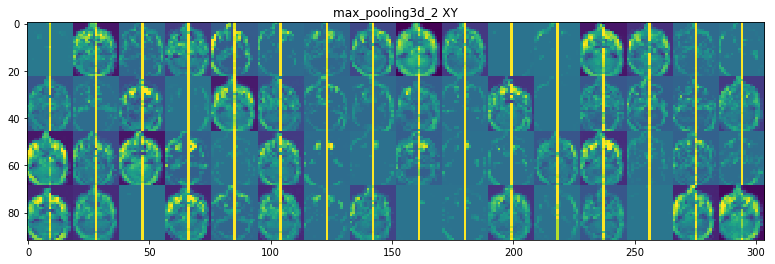

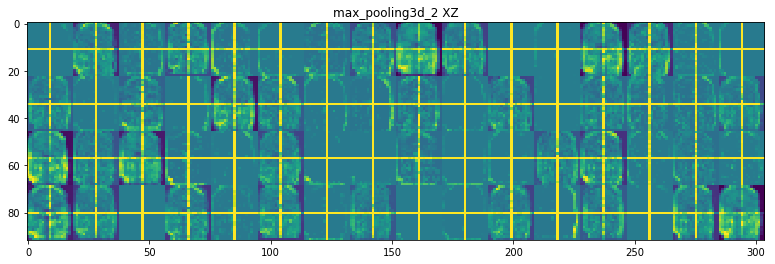

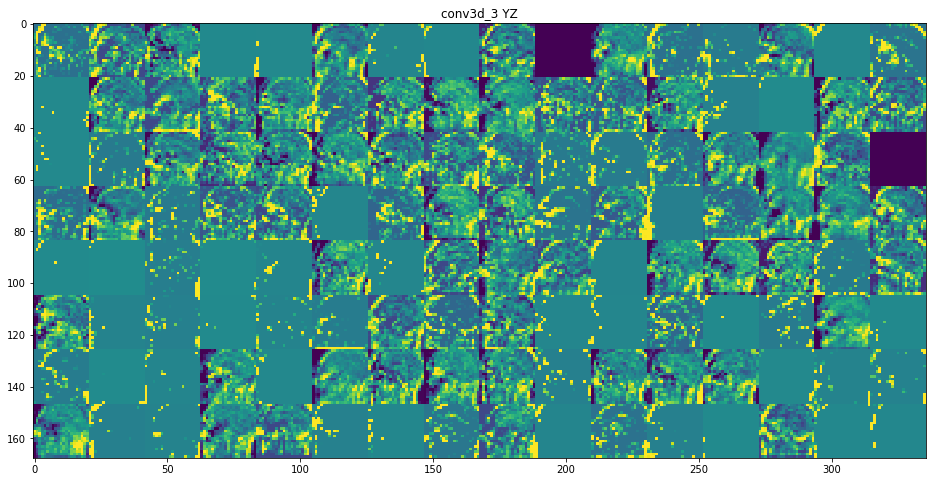

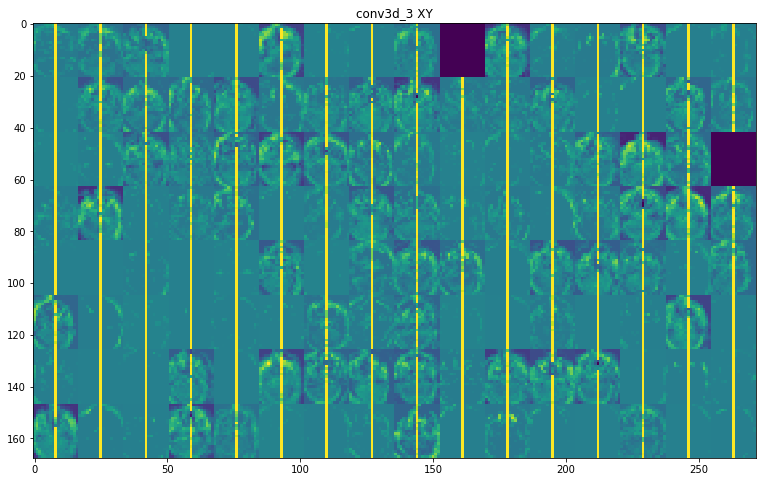

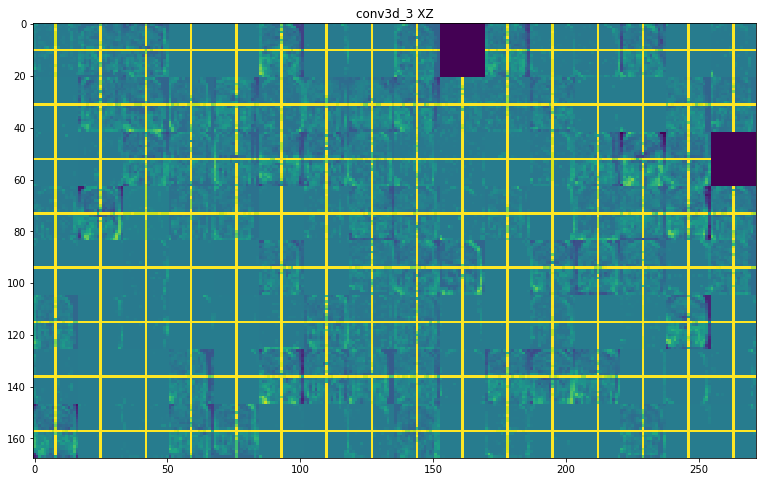

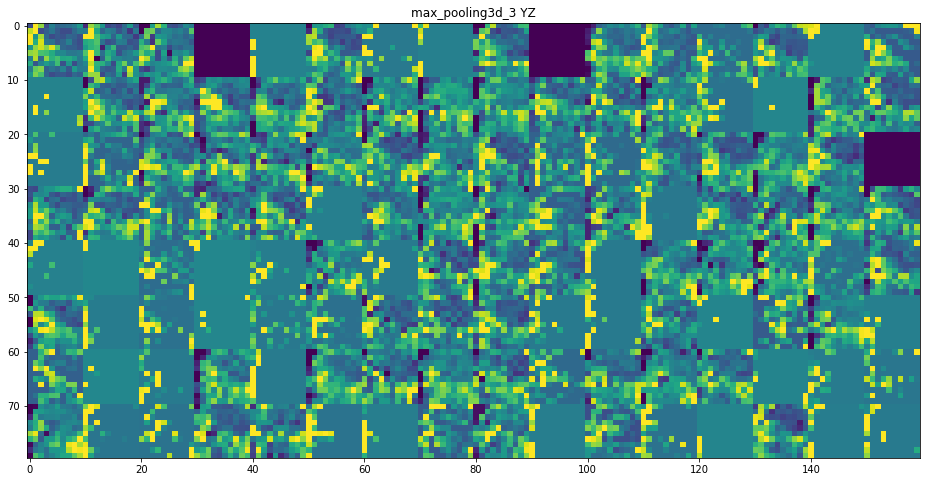

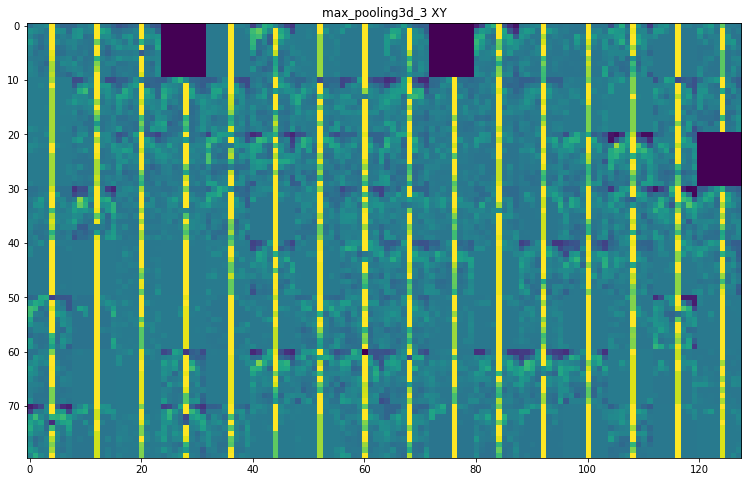

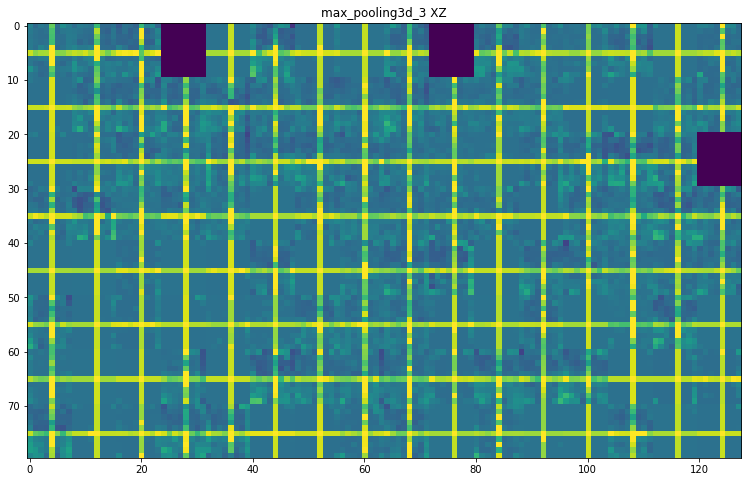

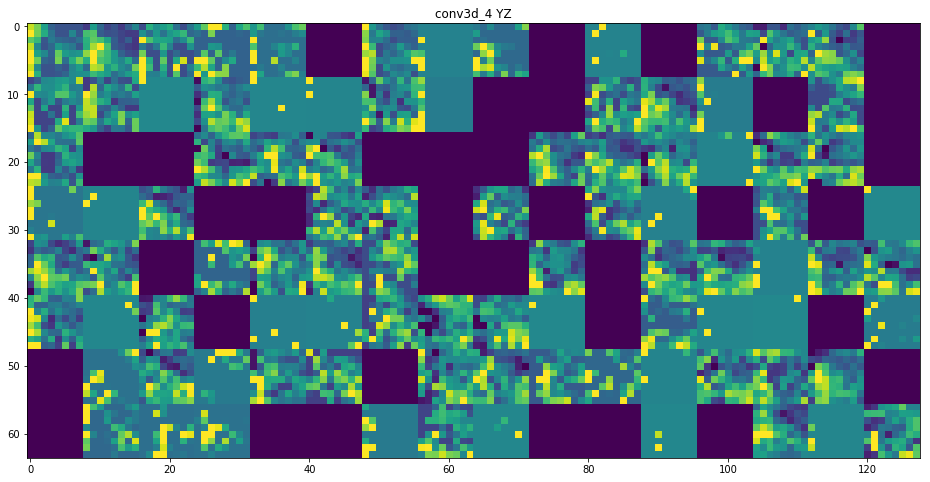

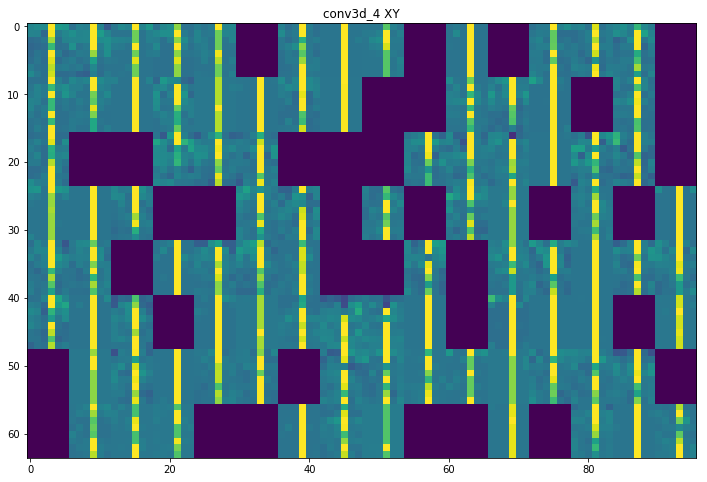

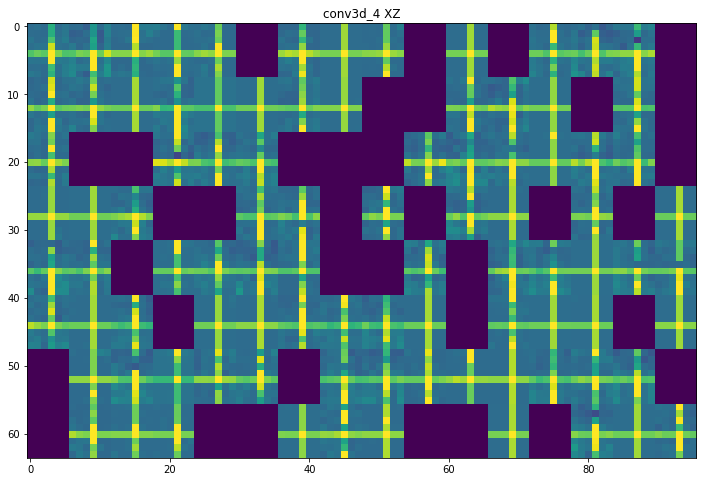

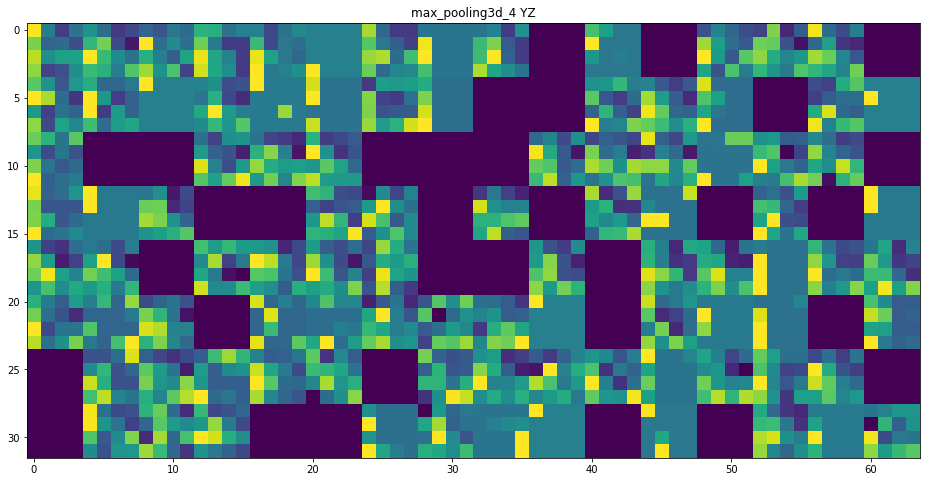

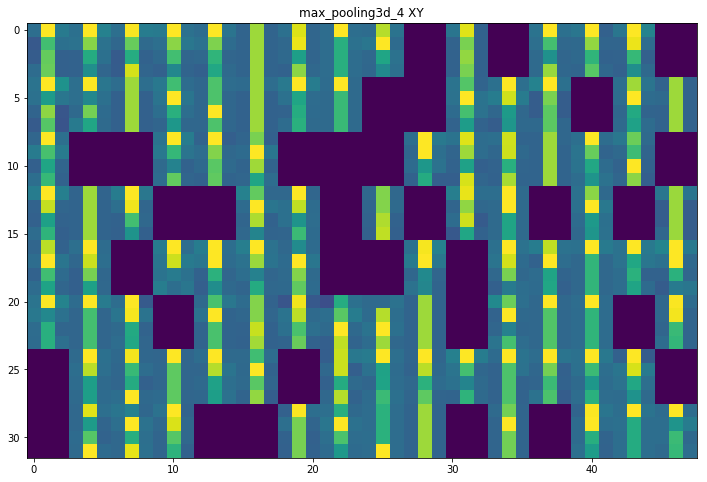

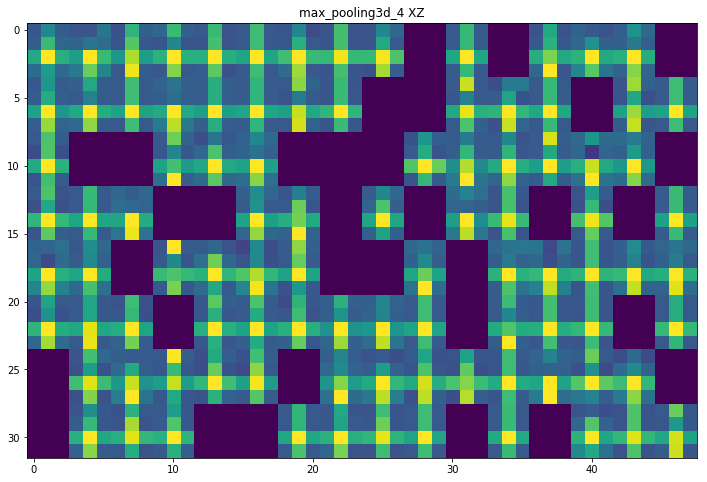

In [14]:
layer_names = []
for layer in model.layers[:9]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    #print('Layer shape',layer_activation.shape)
    #print("nfeatures:",n_features)
    
    #print("info:",layer_activation.shape[3]//2)
    #size = layer_activation.shape[1]
    #size_x = layer_activation.shape[1]
    #size_y = layer_activation.shape[2]
    #size_z = layer_activation.shape[3]
        
    n_rows = (n_features // (images_per_row+1)) + 1
    
    if n_rows == 1: 
        n_cols = n_features 
    if n_rows > 1:     
        n_cols = images_per_row 
    
    for i in range(3):   
        
        #print('plano:',i)
        
        if i==0:
            size_x = layer_activation.shape[1]
            size_y = layer_activation.shape[2]
            plane_name = ' YZ'
        if i==1:
            size_x = layer_activation.shape[2]
            size_y = layer_activation.shape[3]
            plane_name = ' XY'
        if i==2:
            size_x = layer_activation.shape[1]
            size_y = layer_activation.shape[3]
            plane_name = ' XZ'

        
        display_grid = np.zeros((size_x * n_rows , size_y * n_cols))

        #print('display_grid.shape: ',display_grid.shape)
        
        #print('n_rows',n_rows)
        
        for row in range(n_rows):
            if row < n_rows-1:                
                n_cols = images_per_row
            if row == n_rows-1:
                n_cols = n_features - (n_rows-1) * images_per_row
            
            
            #print('n_cols',n_cols)
                
            for col in range(n_cols):
                #print('row:',row,' col:',col)
                if i==0:
                    channel_image = layer_activation[0,:,:,layer_activation.shape[3]//2,row * n_cols + col]
                    #channel_image = layer_activation[0,:, :,col * images_per_row + row]
                if i==1:
                    channel_image = layer_activation[0,layer_activation.shape[1]//2,:,:,row * n_cols + col]
                if i==2:
                    channel_image = layer_activation[0,:,layer_activation.shape[2]//2,:,row * n_cols + col]
                
                #print('channel_image.shape: ',channel_image.shape)
                
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                #display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
                display_grid[row * size_x : (row + 1) * size_x,col * size_y : (col + 1) * size_y] = channel_image

        scale = 1. / size_x
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name + plane_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        #plt.imshow(channel_image,cmap=plt.cm.gray)

In [15]:
        plt.show

<function matplotlib.pyplot.show(*args, **kw)>